In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import warnings, pickle
warnings.filterwarnings('ignore')

In [2]:
# Reading the data
data = pd.read_csv(r"C:\Users\bhupe\Downloads\Copy of bankruptcy-prevention.csv", delimiter = ';')

In [3]:
data

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,class
0,0.5,1.0,0.0,0.0,0.0,0.5,bankruptcy
1,0.0,1.0,0.0,0.0,0.0,1.0,bankruptcy
2,1.0,0.0,0.0,0.0,0.0,1.0,bankruptcy
3,0.5,0.0,0.0,0.5,0.0,1.0,bankruptcy
4,1.0,1.0,0.0,0.0,0.0,1.0,bankruptcy
...,...,...,...,...,...,...,...
245,0.0,1.0,1.0,1.0,1.0,1.0,non-bankruptcy
246,1.0,1.0,0.5,1.0,1.0,0.0,non-bankruptcy
247,0.0,1.0,1.0,0.5,0.5,0.0,non-bankruptcy
248,1.0,0.0,0.5,1.0,0.5,0.0,non-bankruptcy


In [4]:
data.duplicated().sum()

147

In [5]:
# Removes extra spaces from column names
data.columns = data.columns.str.strip()

In [6]:
data.isnull().sum()

industrial_risk          0
management_risk          0
financial_flexibility    0
credibility              0
competitiveness          0
operating_risk           0
class                    0
dtype: int64

In [7]:
data.dtypes

industrial_risk          float64
management_risk          float64
financial_flexibility    float64
credibility              float64
competitiveness          float64
operating_risk           float64
class                     object
dtype: object

In [8]:
# Mapping real values
risk_map = {0: 'Low', 0.5: 'Medium', 1: 'High'}

# Define reusable plotting function
def plot_column(col_name):
    (data[col_name]
     .map(risk_map)
     .value_counts() # counts the occurence of each value
     .reindex(['Low', 'Medium', 'High']) # displays with this order
     .plot(kind='bar', color=['green', 'orange', 'red']))

    plt.title(f'Frequency of {col_name.replace("_", " ").title()}') # Replace the '_' with a space (' ')
    plt.xticks(rotation=0)
    plt.ylabel('Count')
    plt.show()

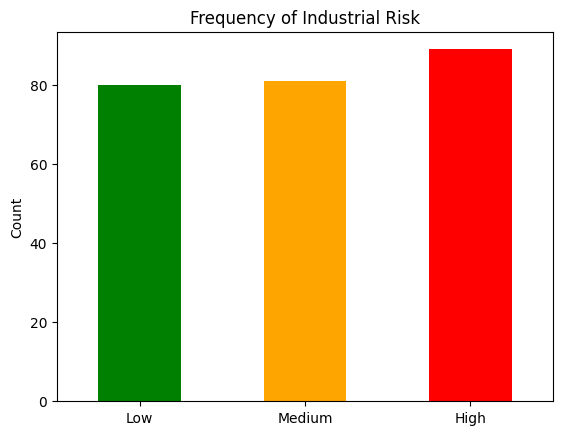

In [9]:
plot_column('industrial_risk')

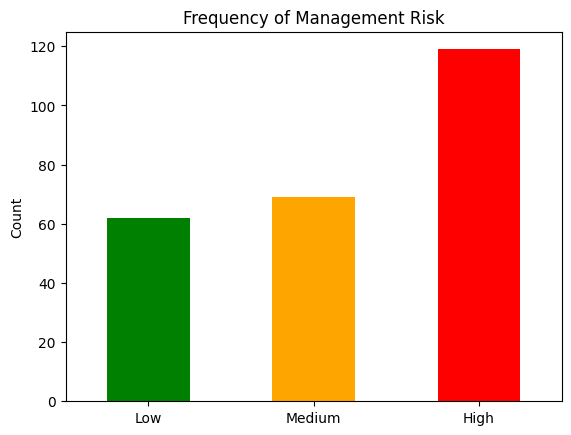

In [10]:
plot_column('management_risk')

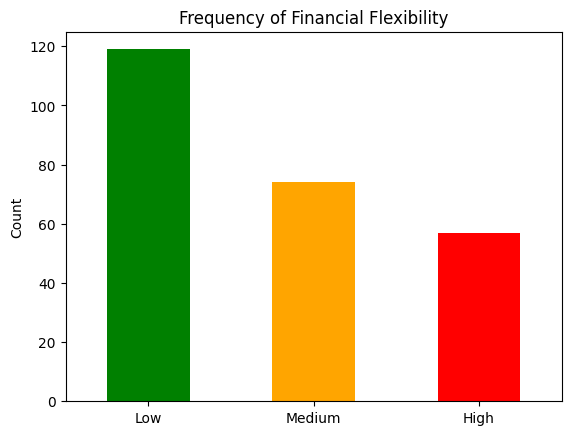

In [11]:
plot_column('financial_flexibility')

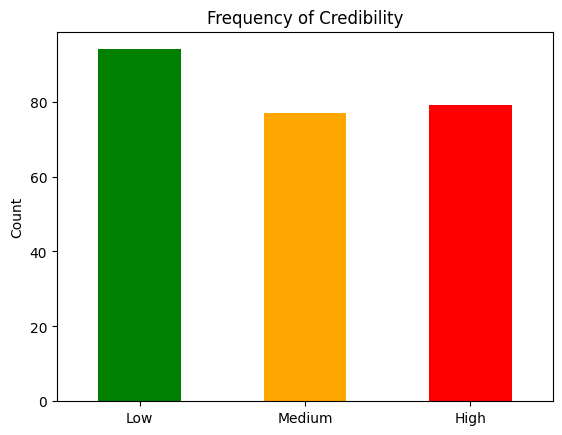

In [12]:
plot_column('credibility')

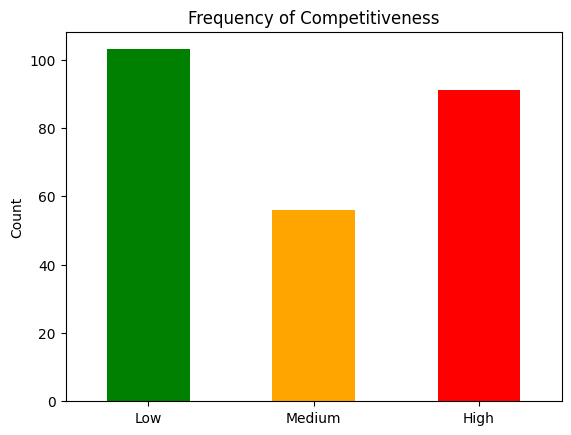

In [13]:
plot_column('competitiveness')

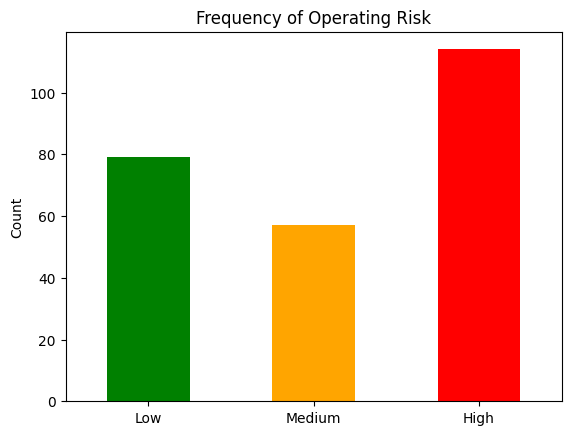

In [14]:
plot_column('operating_risk')

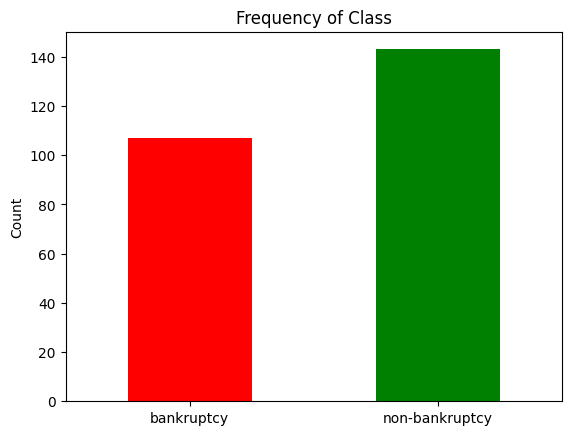

In [15]:
data['class'].value_counts().sort_index().plot(kind = 'bar', color=['red', 'green'])
plt.title('Frequency of Class')
plt.ylabel('Count')
plt.xticks(rotation = 0);

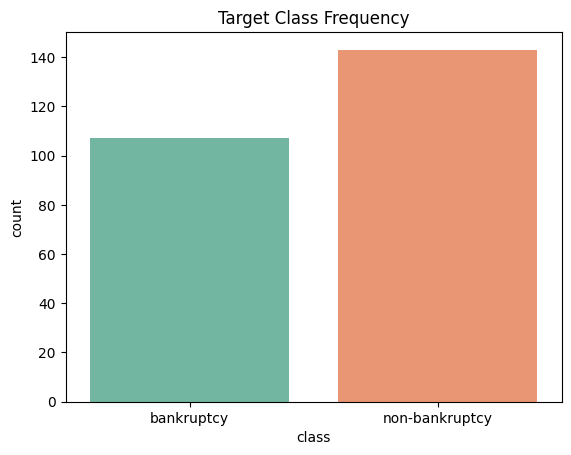

In [16]:
sns.countplot(x='class', data = data, palette = 'Set2')
plt.title('Target Class Frequency');

<Axes: >

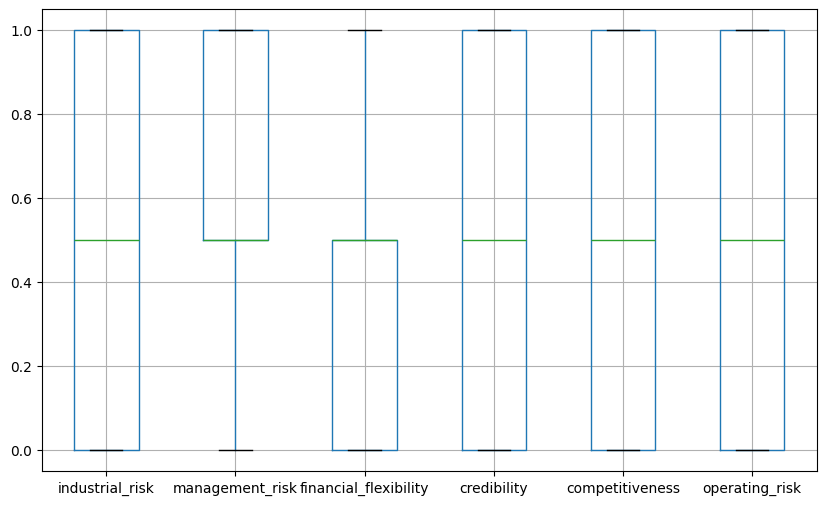

In [17]:
plt.figure(figsize=(10, 6))
# Plotting Boxplot
data.boxplot()

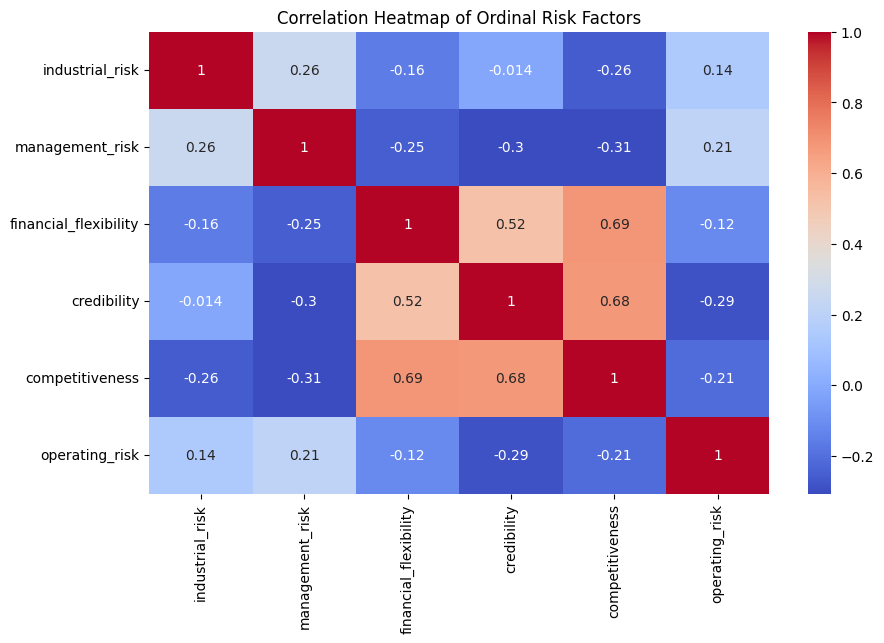

In [18]:
plt.figure(figsize=(10, 6))
# Plotting correlation heatmap
sns.heatmap(data.corr(), annot = True, cmap = 'coolwarm')
plt.title("Correlation Heatmap of Ordinal Risk Factors");

In [19]:
# Addressing multicollinearity
# Make a copy of the dataset excluding the class/target column
X = data.drop(columns=['class']) 

# Add constant for VIF
X_const = add_constant(X)

# Calculate VIF
vif = pd.DataFrame()
vif["Feature"] = X_const.columns # Adding feature column in vif dataframe
# Calculating VIF
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif)

                 Feature       VIF
0                  const  9.534951
1        industrial_risk  1.208550
2        management_risk  1.205396
3  financial_flexibility  1.931439
4            credibility  2.128103
5        competitiveness  2.788219
6         operating_risk  1.134261


In [20]:
# Encoding Categorical variables
le = LabelEncoder()
y = le.fit_transform(data['class'])
# 0 is bankruptcy and 1 is non-bankruptcy

In [21]:
x = data.iloc[:, 0:6]

In [22]:
# stratify = y ensures that minority classes exists in both training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 42)

In [23]:
models = {
    'LogisticRegression':{
        'Model': LogisticRegression(random_state = 42),
        'Params': {
             'C': [0.01, 0.1, 1, 10, 100],
             'penalty': ['l2'],             
             'solver': ['liblinear', 'saga']
            }
          },
    'RandomForest': {
        'Model': RandomForestClassifier(random_state = 42),
        'Params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30]
            }
         },
    'LightGBM': {
        'Model': LGBMClassifier(verbosity=-1, random_state = 42),
        'Params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1]
            }
         },
    'XGBoost': {
        'Model': XGBClassifier(random_state = 42),
        'Params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.2]
        }
    }
}

In [24]:
# Hyperparameter Tuning
best_models = {}

for name, config in models.items():
    print(f'Tuning {name}...')
    random = RandomizedSearchCV(config['Model'], config['Params'], cv = 5, 
                                scoring = 'accuracy', verbose = 0, n_iter = 10)
    random.fit(x_train, y_train)
    best_models[name] = random.best_estimator_ 
    print(f"Best Score for {name}: {random.best_score_:.4f}")
    print(f"Best Params for {name}: {random.best_params_}\n")
    

Tuning LogisticRegression...
Best Score for LogisticRegression: 0.9943
Best Params for LogisticRegression: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}

Tuning RandomForest...
Best Score for RandomForest: 1.0000
Best Params for RandomForest: {'n_estimators': 200, 'max_depth': 10}

Tuning LightGBM...
Best Score for LightGBM: 1.0000
Best Params for LightGBM: {'n_estimators': 100, 'learning_rate': 0.05}

Tuning XGBoost...
Best Score for XGBoost: 0.9886
Best Params for XGBoost: {'n_estimators': 200, 'learning_rate': 0.01}



In [25]:
for name, model in best_models.items():
    print(f"Evaluating model: {name}")
    
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    y_pred = model.predict(x_test)

    print(f"   Training Accuracy: {train_acc:.4f}")
    print(f"   Testing Accuracy:  {test_acc:.4f}")
    print(f"   Classification Report:\n {classification_report(y_test, y_pred)}")
    print('-'*100)

Evaluating model: LogisticRegression
   Training Accuracy: 0.9943
   Testing Accuracy:  1.0000
   Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        43

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75

----------------------------------------------------------------------------------------------------
Evaluating model: RandomForest
   Training Accuracy: 1.0000
   Testing Accuracy:  1.0000
   Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        43

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75

-------

In [26]:
logr = LogisticRegression(solver = 'liblinear', penalty = 'l2', C = 0.1)
logr.fit(x_train, y_train)

LogisticRegression(C=0.1, solver='liblinear')

In [27]:
with open('E://Models//Bankruptcy_model.pkl', 'wb') as f:
    pickle.dump(logr, f)